In [13]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


import matplotlib.pyplot as plt
from scipy.stats import norm
from networks2 import *
from BS_generator import *






In [27]:
class Net_LV_Improved(nn.Module):
    """
    Calibration of LV model: dS_t = S_t*r*dt + L(t,S_t,theta)dW_t to vanilla prices at different maturities
    Improved architecture with residual connections and deeper layers
    """
    def __init__(self, dim, timegrid, strikes_call,  n_layers, vNetWidth, device, rate, maturities, n_maturities):
        super(Net_LV_Improved, self).__init__()

        self.dim = dim
        self.timegrid = timegrid
        self.device = device
        self.strikes_call = strikes_call
        self.maturities = maturities
        self.rate = rate

     
        self.diffusion = Net_LSTM_Grid(
            input_dim=dim + 1, 
            lstm_hidden_dim=40,  
            lstm_layers=6,      
            output_dim=1,       
            n_maturities=n_maturities
        )

        self.control_variate_vanilla = Net_LSTM_Grid(
            input_dim=dim + 1,
            lstm_hidden_dim=40,
            lstm_layers=6,
            output_dim=len(strikes_call) * n_maturities,
            n_maturities=n_maturities
        )

        self.control_variate_exotics = Net_LSTM_Grid(
            input_dim=dim * len(self.timegrid) + 1,
            lstm_hidden_dim=1,
            lstm_layers=1,
            output_dim=1,
            n_maturities=n_maturities
        )
    def forward(self, S0, z, MC_samples, ind_T, period_length=30):
        """
        Forward pass for evaluation with added residuals
        """

        ones = torch.ones(MC_samples, 1, device=self.device)
        path = torch.zeros(MC_samples, len(self.timegrid), device=self.device)
        S_old = ones * S0
        path[:,0] = S_old.squeeze(1)

        cv_vanilla = torch.zeros(S_old.shape[0], len(self.strikes_call)*len(self.maturities), device=self.device)
        price_vanilla_cv = torch.zeros(len(self.maturities), len(self.strikes_call), device=self.device)
        var_price_vanilla_cv = torch.zeros_like(price_vanilla_cv)

        cv_exotics = torch.zeros(S_old.shape[0], 1, device=self.device)

        exotic_option_price = torch.zeros_like(S_old)

        running_max = S_old


        for i in range(1, ind_T+1):
            idx = (i-1)//period_length
            t = torch.ones_like(S_old) * self.timegrid[i-1]
            h = self.timegrid[i] - self.timegrid[i-1]
            dW = (torch.sqrt(h) * z[:, i-1]).reshape(MC_samples, 1)

   
            diffusion_input = torch.cat([t, S_old], 1) 
            diffusion = self.diffusion.forward_idx(idx, diffusion_input)
            S_new = S_old + self.rate * S_old * h / (1 + self.rate * S_old.detach() * torch.sqrt(h)) + S_old * diffusion * dW / (1 + S_old.detach() * diffusion.detach() * torch.sqrt(h))

                                      
            cv_vanilla += torch.exp(-self.rate * self.timegrid[i-1]) * S_old.detach() * diffusion.detach() * self.control_variate_vanilla.forward_idx(idx, torch.cat([t, S_old.detach()], 1)) * dW.repeat(1, len(self.strikes_call)*len(self.maturities))
            cv_exotics += torch.exp(-self.rate * self.timegrid[i-1]) * S_old.detach() * diffusion.detach() * self.control_variate_exotics.forward_idx(idx, torch.cat([t, path], 1)) * dW

            S_old = S_new
            path[:, i] = S_old.detach().squeeze(1)

            running_max = torch.max(running_max, S_old)
            if i in self.maturities:
                ind_maturity = self.maturities.index(i)
                for idx, strike in enumerate(self.strikes_call):
                    cv = cv_vanilla.view(-1, len(self.maturities), len(self.strikes_call))
                    price_vanilla = torch.exp(-self.rate * self.timegrid[i]) * torch.clamp(S_old - strike, 0).squeeze(1) - cv[:, ind_maturity, idx]
                    price_vanilla_cv[ind_maturity, idx] = price_vanilla.mean()
                    var_price_vanilla_cv[ind_maturity, idx] = price_vanilla.var()

        exotic_option_price = running_max - S_old
        error = torch.exp(-self.rate * self.timegrid[ind_T]) * exotic_option_price.detach() - torch.mean(torch.exp(-self.rate * self.timegrid[ind_T]) * exotic_option_price.detach()) - cv_exotics.detach()
        exotic_option_price = torch.exp(-self.rate * self.timegrid[ind_T]) * exotic_option_price - cv_exotics

        return price_vanilla_cv, var_price_vanilla_cv, exotic_option_price, exotic_option_price.mean(), exotic_option_price.var(), error

In [15]:
def train_nsde_improved(model, z_test, config):
    """
    Trains the improved Neural SDE model on target option prices (e.g. from the BS model).
    Returns the best model along with lists of RMSE and hedge error (MSE) for each epoch.
    """
    import time
    import torch.nn as nn

    loss_fn = nn.MSELoss()
    n_maturities = len(config["maturities"])
    model = model.to(device)

    params_SDE = list(model.diffusion.parameters())
    n_epochs = config["n_epochs"]
    T = config["maturities"][-1]
    

    target_mat_T = torch.tensor(config["target_data"][:n_maturities, :len(config["strikes_call"])],
                                device=device).float()
    
    optimizer_SDE = torch.optim.Adam(params_SDE, lr=0.001)
    optimizer_CV = torch.optim.Adam(list(model.control_variate_vanilla.parameters()) + 
                                    list(model.control_variate_exotics.parameters()), lr=0.001)
    scheduler_SDE = torch.optim.lr_scheduler.MultiStepLR(optimizer_SDE, milestones=[500,800], gamma=0.2)
    
    loss_val_best = 10
    itercount = 0
    
    rmse_list = []
    hedge_error_list = []
    
    
    model_best = model

    for epoch in range(n_epochs):

        requires_grad_CV = (epoch+1) % 2 == 0
        if requires_grad_CV:
            model.control_variate_vanilla.unfreeze()
            model.control_variate_exotics.unfreeze()
            model.diffusion.freeze()
        else:
            model.diffusion.unfreeze()
            model.control_variate_vanilla.freeze()
            model.control_variate_exotics.freeze()
        
        print(f'\nEpoch {epoch}/{n_epochs}')
        batch_size = config["batch_size"]
        
        for i in range(0, 20 * batch_size, batch_size):
            batch_z = torch.randn(batch_size, config["n_steps"], device=device)
            optimizer_SDE.zero_grad()
            optimizer_CV.zero_grad()
            
            init_time = time.time()
    
            pred, var, _, exotic_option_price, exotic_option_var, error = model(S0, batch_z, batch_size, T, period_length=16)
            itercount += 1
            
            if requires_grad_CV:
                loss = var.sum() + exotic_option_var
                loss.backward()
                nn.utils.clip_grad_norm_(list(model.control_variate_vanilla.parameters()) + list(model.control_variate_exotics.parameters()), 3)
                optimizer_CV.step()
            else:
                MSE = loss_fn(pred, target_mat_T)
                loss = MSE
                loss.backward()
                nn.utils.clip_grad_norm_(params_SDE, 5)
                optimizer_SDE.step()
            
            time_forward = time.time() - init_time
            print(f'Iteration {itercount}, Loss = {loss.item():.4e}, Time Forward = {time_forward:.4f}')
        
        scheduler_SDE.step()
        
        with torch.no_grad():
            pred, _, exotic_option_price, exotic_price_mean, exotic_price_var, error = model(S0, z_test, z_test.shape[0], T, period_length=16)
        
        error_hedge = error
        error_hedge_MSE = torch.mean(error_hedge ** 2)
        error_hedge_max = torch.max(torch.abs(error_hedge))
        rmse = torch.sqrt(loss_fn(pred, target_mat_T))
        
     
        print(f"Epoch {epoch}:")
        print(f"    Hedge Error (MSE) = {error_hedge_MSE.item():.4f}")
        print(f"    Hedge Error (Max) = {error_hedge_max.item():.4f}")
        print(f"    RMSE              = {rmse.item():.4f}")
        
        rmse_list.append(rmse.item())
        hedge_error_list.append(error_hedge_MSE.item())
        
        if rmse < loss_val_best:
            model_best = model
            loss_val_best = rmse
            print(f'    New Best Model Found with RMSE = {rmse.item():.4f}')
    
            filename = f"Neural_SDE_Improved_{epoch}_AugmentedLagrangian.pth.tar"
            checkpoint = {
                "state_dict": model.state_dict(),
                "exotic_price_mean": exotic_price_mean,
                "exotic_price_var": exotic_price_var,
                "T": T,
                "pred": pred,
                "target_mat_T": target_mat_T
            }
            torch.save(checkpoint, filename)
        
        if rmse.item() < 2e-5:
            break
    
    return model_best, rmse_list, hedge_error_list


In [16]:

S = 1.0
r_value = 0.025
sigma_value = 0.2
strikes_call = np.arange(0.8, 1.21, 0.02)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

n_steps = 96
timegrid = torch.linspace(0, 1, n_steps+1).to(device)
timegrid_np = np.linspace(0, 1, n_steps+1)

maturity_indices = [16, 32, 48, 64]
maturities_times = timegrid_np[maturity_indices]


target_data = generate_option_prices(S, r_value, sigma_value, maturities_times, strikes_call, option_type='call')


maturities = list(range(16, 65, 16))
n_maturities = len(maturities)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

S0 = 1.0


MC_samples_test = 200000
z_test = torch.randn(MC_samples_test, n_steps, device=device)
z_test = torch.cat([z_test, -z_test], 0)


CONFIG = {
    "batch_size": 100,
    "n_epochs": 30, 
    "maturities": maturities, 
    "n_maturities": n_maturities,
    "strikes_call": strikes_call,
    "timegrid": timegrid,
    "n_steps": n_steps,
    "target_data": target_data 
}


model = Net_LV_Improved(
    dim=1, 
    timegrid=timegrid, 
    strikes_call=strikes_call, 
    n_layers=5, 
    vNetWidth=50, 
    device=device, 
    rate=r_value, 
    maturities=maturities, 
    n_maturities=n_maturities
)
model.to(device)



model, rmse_list, hedge_error_list = train_nsde_improved(model, z_test, CONFIG)


Using device: cuda:0
Using device: cuda:0

Epoch 0/30
Iteration 1, Loss = 8.5931e-03, Time Forward = 0.1739
Iteration 2, Loss = 1.1884e-02, Time Forward = 0.1623
Iteration 3, Loss = 9.7106e-03, Time Forward = 0.1609
Iteration 4, Loss = 1.0295e-02, Time Forward = 0.1587
Iteration 5, Loss = 8.8234e-03, Time Forward = 0.1588
Iteration 6, Loss = 1.5066e-02, Time Forward = 0.1577
Iteration 7, Loss = 1.1506e-02, Time Forward = 0.1591
Iteration 8, Loss = 1.1688e-02, Time Forward = 0.1574
Iteration 9, Loss = 1.3607e-02, Time Forward = 0.1580
Iteration 10, Loss = 1.2220e-02, Time Forward = 0.1571
Iteration 11, Loss = 9.7332e-03, Time Forward = 0.1576
Iteration 12, Loss = 7.2717e-03, Time Forward = 0.1576
Iteration 13, Loss = 7.7055e-03, Time Forward = 0.1579
Iteration 14, Loss = 9.9036e-03, Time Forward = 0.1577
Iteration 15, Loss = 1.0204e-02, Time Forward = 0.1575
Iteration 16, Loss = 7.7091e-03, Time Forward = 0.1576
Iteration 17, Loss = 1.4729e-02, Time Forward = 0.1575
Iteration 18, Loss =

Estimated sigma from neural SDE (MC average of diffusion values): 0.19408153
True sigma: 0.2


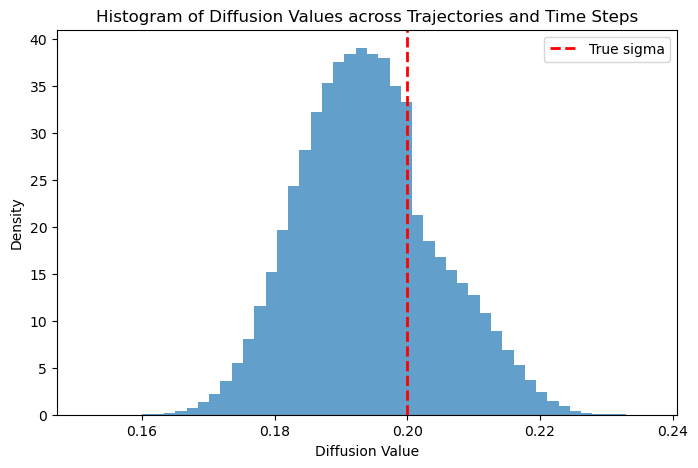

In [17]:
def simulate_diffusion(model, S0, MC_samples, n_steps, period_length=16):
    """
    Simulates trajectories using the trained Neural SDE and records the diffusion values at each time step.
    Returns an array of shape (MC_samples, n_steps) containing diffusion values.
    """
    model.eval()  
    diffusion_vals = [] 
    ones = torch.ones(MC_samples, 1, device=device)
    S_old = ones * S0
    

    for i in range(1, n_steps+1):
        idx = (i-1) // period_length
        t = torch.ones_like(S_old) * timegrid[i-1]
        diffusion = model.diffusion.forward_idx(idx, torch.cat([t, S_old], 1))
        diffusion_vals.append(diffusion.detach().cpu().numpy())
        
        h = timegrid[i] - timegrid[i-1]
        dW = torch.sqrt(h) * torch.randn(MC_samples, 1, device=device)
        S_new = S_old + r_value * S_old * h/(1 + r_value * S_old.detach()*torch.sqrt(h)) \
                     + S_old * diffusion * dW/(1 + S_old.detach()*diffusion.detach()*torch.sqrt(h))
        S_old = S_new
    
  
    diffusion_vals = np.concatenate(diffusion_vals, axis=1)
    return diffusion_vals


MC_samples_sim = 10000
diff_vals = simulate_diffusion(model, S0, MC_samples_sim, n_steps, period_length=30)


estimated_sigma = np.mean(diff_vals)
print("Estimated sigma from neural SDE (MC average of diffusion values):", estimated_sigma)
print("True sigma:", sigma_value)

plt.figure(figsize=(8,5))
plt.hist(diff_vals.flatten(), bins=50, density=True, alpha=0.7)
plt.axvline(sigma_value, color='red', linestyle='dashed', linewidth=2, label='True sigma')
plt.xlabel("Diffusion Value")
plt.ylabel("Density")
plt.title("Histogram of Diffusion Values across Trajectories and Time Steps")
plt.legend()
plt.show()


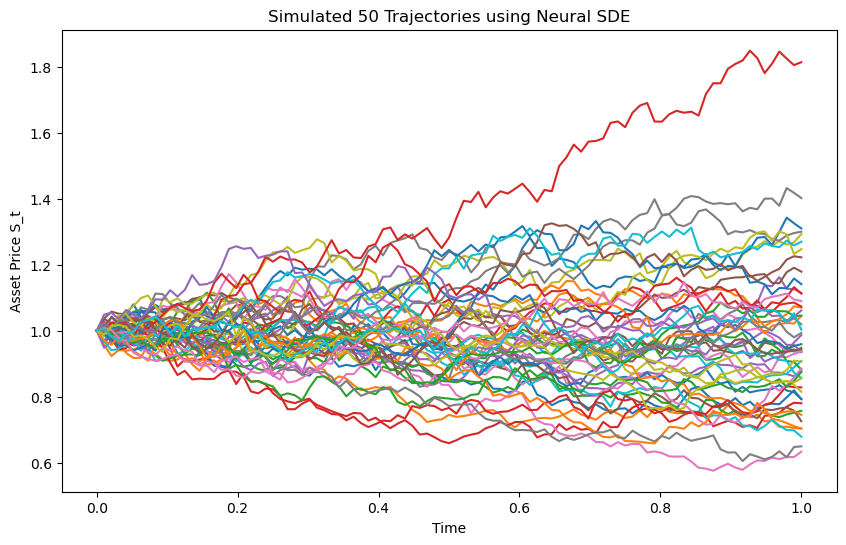

In [18]:

def simulate_paths(model, S0, MC_samples, n_steps, period_length=16):

    model.eval()
    ones = torch.ones(MC_samples, 1, device=device)
    S_old = ones * S0
    paths = torch.zeros(MC_samples, n_steps+1, device=device)
    paths[:, 0] = S_old.squeeze(1)
    
    for i in range(1, n_steps+1):

        idx = min((i-1) // period_length, len(maturities) - 1)
        t = torch.ones_like(S_old) * timegrid[i-1]
        h = timegrid[i] - timegrid[i-1]
        diffusion = model.diffusion.forward_idx(idx, torch.cat([t, S_old], 1))
        dW = torch.sqrt(h) * torch.randn(MC_samples, 1, device=device)
        S_new = S_old + r_value * S_old * h / (1 + r_value * S_old.detach() * torch.sqrt(h)) \
                    + S_old * diffusion * dW / (1 + S_old.detach() * diffusion.detach() * torch.sqrt(h))
        paths[:, i] = S_new.squeeze(1)
        S_old = S_new
    return paths.detach().cpu().numpy()


MC_samples_sim_paths = 50
simulated_paths = simulate_paths(model, S0, MC_samples_sim_paths, n_steps, period_length=16)


time_points = timegrid.cpu().numpy()


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(MC_samples_sim_paths):
    plt.plot(time_points, simulated_paths[i, :], lw=1.5)
plt.xlabel("Time")
plt.ylabel("Asset Price S_t")
plt.title("Simulated 50 Trajectories using Neural SDE")
plt.show()


In [19]:
def predict_sigma_direct(model):

    t = torch.tensor([[timegrid[0]]], device=device)
    S_val = torch.tensor([[1.0]], device=device)
    sigma_pred = model.diffusion.forward_idx(0, torch.cat([t, S_val], 1))
    return sigma_pred.item()

def predict_sigma_via_trajectories(model, S0=1.0, n_steps=96, period_length=16, MC_samples=1000):

    model.eval()
    ones = torch.ones(MC_samples, 1, device=device)
    S_old = ones * S0
    diffusion_vals = []
    for i in range(1, n_steps+1):
   
        idx = min((i-1) // period_length, len(model.diffusion.net_t) - 1)
        t = torch.ones_like(S_old) * timegrid[i-1]
        diffusion = model.diffusion.forward_idx(idx, torch.cat([t, S_old], 1))
        diffusion_vals.append(diffusion.detach().cpu().numpy())
        h = timegrid[i] - timegrid[i-1]
        dW = torch.sqrt(h) * torch.randn(MC_samples, 1, device=device)
        S_new = S_old + 0.025 * S_old * h / (1 + 0.025 * S_old.detach() * torch.sqrt(h)) \
                + S_old * diffusion * dW / (1 + S_old.detach() * diffusion.detach() * torch.sqrt(h))
        S_old = S_new
    diffusion_vals = np.concatenate(diffusion_vals, axis=1)
    sigma_traj = np.mean(diffusion_vals)
    return sigma_traj


=== Training model for sigma = 0.1 ===

Epoch 0/30
Iteration 1, Loss = 8.7624e-03, Time Forward = 0.1303


Iteration 2, Loss = 1.0080e-02, Time Forward = 0.1687
Iteration 3, Loss = 9.4897e-03, Time Forward = 0.1285
Iteration 4, Loss = 9.9640e-03, Time Forward = 0.1259
Iteration 5, Loss = 8.2194e-03, Time Forward = 0.1261
Iteration 6, Loss = 9.0990e-03, Time Forward = 0.1286
Iteration 7, Loss = 1.0005e-02, Time Forward = 0.1442
Iteration 8, Loss = 8.6357e-03, Time Forward = 0.1281
Iteration 9, Loss = 8.6699e-03, Time Forward = 0.1271
Iteration 10, Loss = 8.5884e-03, Time Forward = 0.1259
Iteration 11, Loss = 8.0154e-03, Time Forward = 0.1221
Iteration 12, Loss = 8.0037e-03, Time Forward = 0.1220
Iteration 13, Loss = 8.5862e-03, Time Forward = 0.1265
Iteration 14, Loss = 7.7298e-03, Time Forward = 0.1280
Iteration 15, Loss = 7.7036e-03, Time Forward = 0.1250
Iteration 16, Loss = 8.6184e-03, Time Forward = 0.1279
Iteration 17, Loss = 8.6549e-03, Time Forward = 0.1271
Iteration 18, Loss = 8.0251e-03, Time Forward = 0.1254
Iteration 19, Loss = 8.5663e-03, Time Forward = 0.1254
Iteration 20, Loss

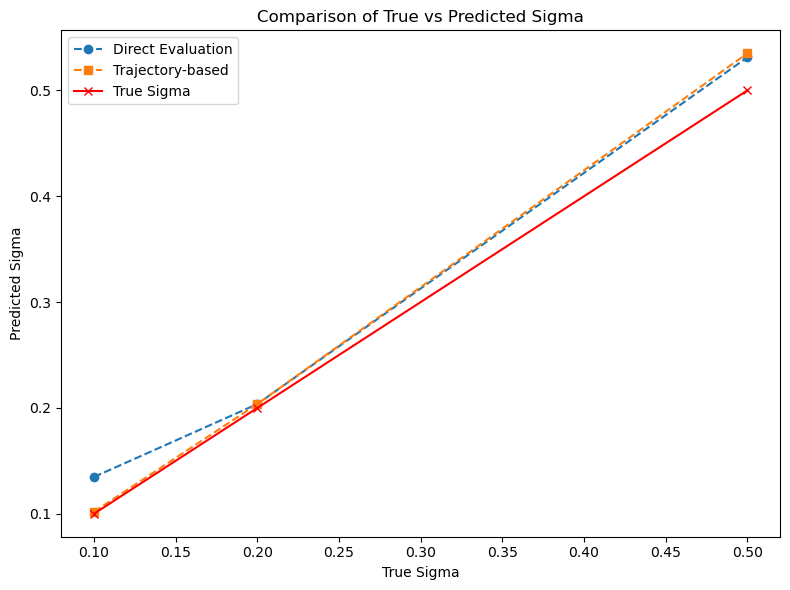

In [20]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from BS_generator import generate_option_prices 
from networks import Net_timegrid 

strikes_call = np.arange(0.8, 1.21, 0.02)
n_steps = 96
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
timegrid = torch.linspace(0, 1, n_steps+1).to(device)
maturities = list(range(16, 64, 16)) 
n_maturities = len(maturities)
r_value = 0.025

MC_samples_test = 20000
z_test = torch.randn(MC_samples_test, n_steps, device=device)
z_test = torch.cat([z_test, -z_test], 0)



def predict_sigma_direct(model):

    model.eval()
    input_tensor = torch.tensor([[0.0, 1.0]], device=device)
    sigma_pred = model.diffusion.forward_idx(0, input_tensor)
    return sigma_pred.item()

def simulate_diffusion(model, S0, MC_samples, n_steps, period_length=16):

    model.eval()
    diffusion_vals = []  
    ones = torch.ones(MC_samples, 1, device=device)
    S_old = ones * S0
    
    for i in range(1, n_steps+1):
        idx = min((i-1) // period_length, len(maturities) - 1)
        t = torch.ones_like(S_old) * timegrid[i-1]
        diffusion = model.diffusion.forward_idx(idx, torch.cat([t, S_old], 1))
        diffusion_vals.append(diffusion.detach().cpu().numpy())
        
        h = timegrid[i] - timegrid[i-1]
        dW = torch.sqrt(h) * torch.randn(MC_samples, 1, device=device)
        S_new = S_old + r_value * S_old * h / (1 + r_value * S_old.detach()*torch.sqrt(h)) \
                    + S_old * diffusion * dW / (1 + S_old.detach()*diffusion.detach()*torch.sqrt(h))
        S_old = S_new
        
    diffusion_vals = np.concatenate(diffusion_vals, axis=1)
    return diffusion_vals

def predict_sigma_via_trajectories(model, S0, n_steps, period_length, MC_samples):

    diff_vals = simulate_diffusion(model, S0, MC_samples, n_steps, period_length)
    sigma_estimate = np.mean(diff_vals)
    return sigma_estimate


sigmas = [0.1, 0.2, 0.5]
results_direct = {}
results_traj = {}


maturities_time = [timegrid[m].item() for m in maturities]

for sigma in sigmas:
    print(f"\n=== Training model for sigma = {sigma} ===")
    option_prices = generate_option_prices(1, r_value, sigma, maturities_time, strikes_call, option_type='call')
    
    CONFIG = {
        "batch_size": 500,
        "n_epochs": 30,
        "maturities": maturities,        
        "n_maturities": n_maturities,
        "strikes_call": strikes_call,
        "timegrid": timegrid,
        "n_steps": n_steps,
        "target_data": option_prices,
    }
    

    model = Net_LV_Improved(
        dim=1, 
        timegrid=timegrid, 
        strikes_call=strikes_call, 
        n_layers=5, 
        vNetWidth=60, 
        device=device, 
        rate=r_value, 
        maturities=maturities, 
        n_maturities=n_maturities
    )
    model.to(device)
    

    z_test = torch.randn(20000, n_steps, device=device)
    z_test = torch.cat([z_test, -z_test], 0)
    

    model, _, _ = train_nsde_improved(model, z_test, CONFIG)
    

    sigma_direct = predict_sigma_direct(model)
    results_direct[sigma] = sigma_direct
    print(f"Direct Evaluation --> True sigma: {sigma} \t Predicted sigma: {sigma_direct}")
    

    sigma_traj = predict_sigma_via_trajectories(model, S0=1.0, n_steps=n_steps, period_length=16, MC_samples=1000)
    results_traj[sigma] = sigma_traj
    print(f"Trajectory-based  --> True sigma: {sigma} \t Predicted sigma (averaged): {sigma_traj}")


true_sigmas = list(results_direct.keys())
predicted_direct = [results_direct[s] for s in true_sigmas]
predicted_traj = [results_traj[s] for s in true_sigmas]
plt.figure(figsize=(8, 6))
plt.plot(true_sigmas, predicted_direct, marker='o', linestyle='--', label="Direct Evaluation")
plt.plot(true_sigmas, predicted_traj, marker='s', linestyle='--', label="Trajectory-based")
plt.plot(true_sigmas, true_sigmas, marker='x', color='red', label="True Sigma")
plt.xlabel("True Sigma")
plt.ylabel("Predicted Sigma")
plt.title("Comparison of True vs Predicted Sigma")
plt.legend()
plt.tight_layout()
plt.show()


Available expirations: ('2025-03-13', '2025-03-14', '2025-03-17', '2025-03-18', '2025-03-19', '2025-03-20', '2025-03-21', '2025-03-28', '2025-03-31', '2025-04-04', '2025-04-11', '2025-04-17', '2025-04-25', '2025-04-30', '2025-05-16', '2025-05-30', '2025-06-20', '2025-06-30', '2025-07-18', '2025-07-31', '2025-08-15', '2025-08-29', '2025-09-19', '2025-09-30', '2025-12-19', '2025-12-31', '2026-01-16', '2026-03-20', '2026-06-18', '2026-12-18', '2027-01-15', '2027-12-17')
Selected monthly expirations: ['2025-03-31', '2025-04-30', '2025-05-30', '2025-06-30', '2025-07-31', '2025-08-29']
Days to expiration for selected expirations: [18, 48, 78, 109, 140, 169]
Maturity indices on timegrid: [1, 2, 3, 4, 5, 6]
Shape of target_data (real option prices): (6, 25)

Epoch 0/50
Iteration 1, Loss = 6.8664e-04, Time Forward = 0.0999
Iteration 2, Loss = 6.9849e-04, Time Forward = 0.0831
Iteration 3, Loss = 7.1007e-04, Time Forward = 0.0787
Iteration 4, Loss = 6.9273e-04, Time Forward = 0.0733
Iteration 5,

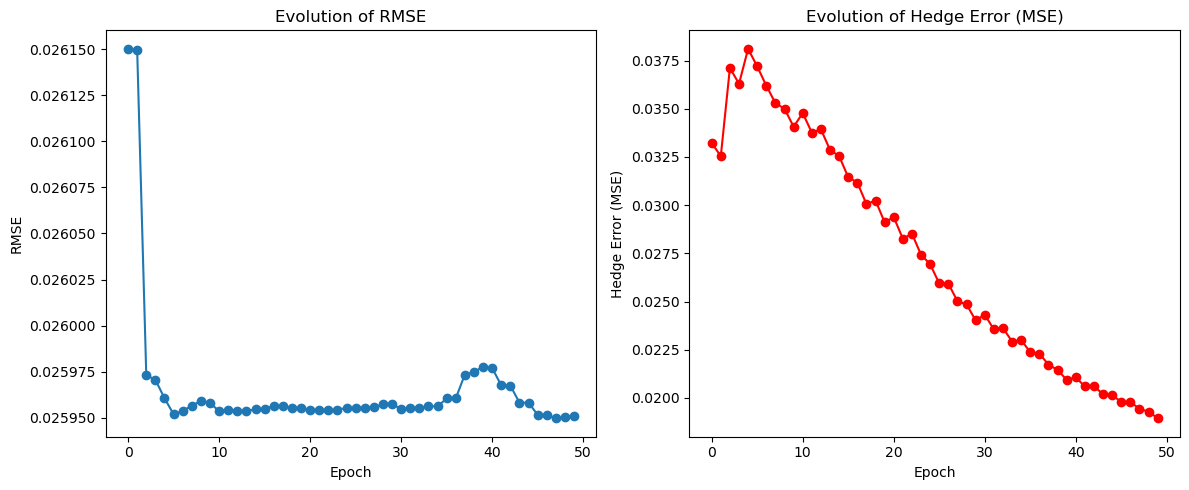

In [28]:
import yfinance as yf
import pandas as pd
import datetime
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict



ticker_symbol = "SPY"
ticker = yf.Ticker(ticker_symbol)
expirations = ticker.options
print("Available expirations:", expirations)

exp_by_month = defaultdict(list)
for exp in expirations:
    date_obj = datetime.datetime.strptime(exp, "%Y-%m-%d").date()
    key = (date_obj.year, date_obj.month)
    exp_by_month[key].append(exp)


monthly_exps = []
for key in sorted(exp_by_month.keys()):
    monthly_exps.append(sorted(exp_by_month[key])[-1])


num_exps = 6
selected_exps = monthly_exps[:num_exps]
print("Selected monthly expirations:", selected_exps)


current_date = datetime.datetime.now().date()
expiration_dates = [datetime.datetime.strptime(exp, "%Y-%m-%d").date() for exp in selected_exps]
T_days = [(exp_date - current_date).days for exp_date in expiration_dates]
print("Days to expiration for selected expirations:", T_days)


n_steps = 96
timegrid = torch.linspace(0, 1, n_steps+1).to(device)

maturities = list(range(1, num_exps+1))
n_maturities = len(maturities)
print("Maturity indices on timegrid:", maturities)


normalized_strikes_target = np.linspace(0.8, 1.2, 25)

target_data_list = []
for exp in selected_exps:
    option_chain = ticker.option_chain(exp)
    calls = option_chain.calls
    underlying_price = ticker.info['regularMarketPrice']
 
    mask = (calls['strike'] >= 0.8 * underlying_price) & (calls['strike'] <= 1.2 * underlying_price)
    calls_filtered = calls[mask]
    norm_strikes = calls_filtered['strike'].values / underlying_price
    norm_prices = calls_filtered['lastPrice'].values / underlying_price

    sort_idx = np.argsort(norm_strikes)
    norm_strikes = norm_strikes[sort_idx]
    norm_prices = norm_prices[sort_idx]
    interp_prices = np.interp(normalized_strikes_target, norm_strikes, norm_prices)
    target_data_list.append(interp_prices)

target_data = np.array(target_data_list)
print("Shape of target_data (real option prices):", target_data.shape)


assert target_data.shape[0] == n_maturities, "Mismatch: number of target maturities and computed maturities differ!"




CONFIG_real = {
    "batch_size": 4000,
    "n_epochs": 50,          
    "maturities": maturities, 
    "n_maturities": n_maturities,
    "strikes_call": normalized_strikes_target,
    "timegrid": timegrid,
    "n_steps": n_steps,
    "target_data": target_data, 
}


model_real = Net_LV_Improved(dim=1, 
                             timegrid=timegrid, 
                             strikes_call=normalized_strikes_target, 
                             n_layers=5, 
                             vNetWidth=50, 
                             device=device, 
                             rate=0.025, 
                             maturities=maturities, 
                             n_maturities=n_maturities)
model_real.to(device)


MC_samples_real = 50000
z_test_real = torch.randn(MC_samples_real, n_steps, device=device)
z_test_real = torch.cat([z_test_real, -z_test_real], 0)


model_real, rmse_list, hedge_error_list = train_nsde_improved(model_real, z_test_real, CONFIG_real)

epochs = range(len(rmse_list))
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, rmse_list, marker='o')
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Evolution of RMSE")
plt.subplot(1, 2, 2)
plt.plot(epochs, hedge_error_list, marker='o', color='red')
plt.xlabel("Epoch")
plt.ylabel("Hedge Error (MSE)")
plt.title("Evolution of Hedge Error (MSE)")
plt.tight_layout()
plt.show()


with torch.no_grad():

    pred, _, _, _, _, _ = model_real(1.0, z_test_real, z_test_real.shape[0], maturities[-1], period_length=16)





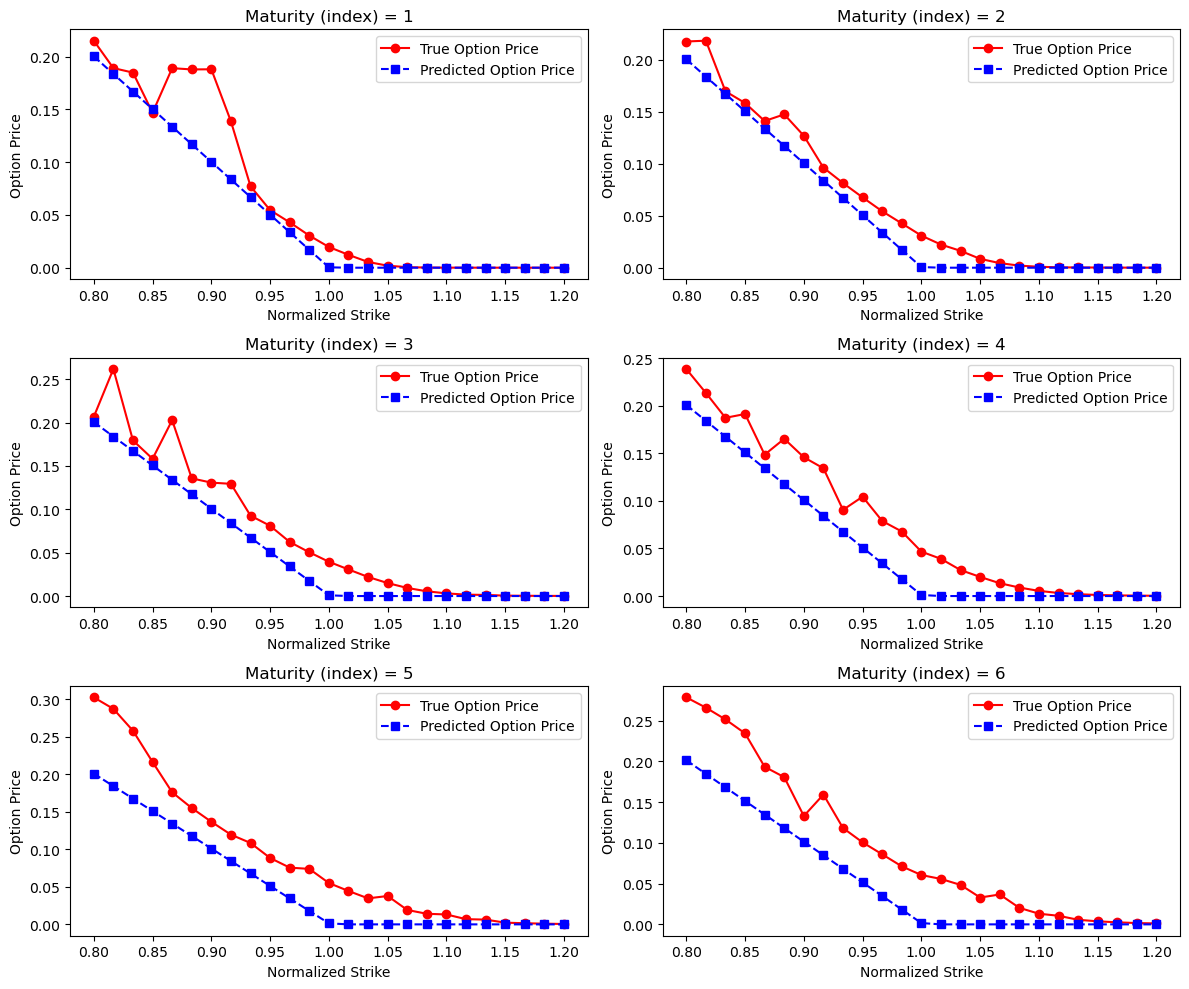

In [22]:
plt.figure(figsize=(12, 10))
for i, m in enumerate(maturities):
    plt.subplot(3, 2, i+1)

    plt.plot(normalized_strikes_target, target_data[i, :], 'ro-', label="True Option Price")
    plt.plot(normalized_strikes_target, pred[i, :].cpu().numpy(), 'bs--', label="Predicted Option Price")
    plt.title(f"Maturity (index) = {m}")
    plt.xlabel("Normalized Strike")
    plt.ylabel("Option Price")
    plt.legend()
plt.tight_layout()
plt.show()